In [2]:
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

In [3]:
modelname = 'bert'

basepath = '../../../results'

og_files = []

candidate_files = []
candidate_files += glob.glob(os.path.join(basepath, f'results_notobe_wiki*xv*MARINVLINZEN_by_clause/{modelname}*_wiki_seed100.txt'))

# the "-mlverbs" tag indicates results where models were trained without 
#   "is" and "are"

for f in candidate_files:
    if '-mlverbs' in f:
        # skip over files marked with -mlverbs
        continue

    og_files.append(f)

#######

unseen_verb_files = []
for f in candidate_files:
    if '-mlverbs' not in f:
        continue

    unseen_verb_files.append(f)

print(len(unseen_verb_files), len(og_files))


15 15


In [5]:
currentdf = pd.read_csv(og_files[0])
currentdf = currentdf.drop(['group'], axis=1).mean()
currentdf = currentdf.to_frame('f1')
currentdf = currentdf.reset_index().rename(columns={'index':'layer'})
currentdf = currentdf.astype({'layer':'int32'})
currentdf['model'] = 'bert'
currentdf = currentdf[currentdf['layer'] > 6]
currentdf

,layer,f1,model
6,7,0.462901,bert
7,8,0.557381,bert
8,9,0.631747,bert
9,10,0.635041,bert
10,11,0.616796,bert
11,12,0.704510,bert


In [6]:
def process_files(files: list) -> list:
    dfs = []
    for i, f in enumerate(files):
        name = None
        parts = os.path.dirname(f).split('_')

        name = parts[2]
        nameparts = name.split('-')

        if 'v' in nameparts[0]:
            name = nameparts[0][:-2]
        else:
            name = nameparts[0]
        
        if 'mlverbs' in parts[2]:
            name += '-mlverbs'

        currentdf = pd.read_csv(f)
        currentdf = currentdf.drop(['group'], axis=1).mean()
        currentdf = currentdf.to_frame('f1')
        currentdf = currentdf.reset_index().rename(columns={'index':'layer'})
        currentdf = currentdf.astype({'layer':'int32'})
        currentdf = currentdf[currentdf['layer'] > 5]
        currentdf['model'] = name

        dfs.append(currentdf)
    
    return dfs


In [7]:
process_files(unseen_verb_files)[-1]

,layer,f1,model
0,6,0.445355,wiki8x-mlverbs
1,7,0.522749,wiki8x-mlverbs
2,8,0.628289,wiki8x-mlverbs
3,9,0.700618,wiki8x-mlverbs
4,10,0.681537,wiki8x-mlverbs
5,11,0.684676,wiki8x-mlverbs
6,12,0.756421,wiki8x-mlverbs


In [8]:
def create_df(dflist: list):
    modeldf = pd.concat(dflist, axis=0)
    modeldf = modeldf.reset_index().drop(['index'], axis=1)
    modeldf = modeldf.sort_values(by=['model', 'layer'])
    # modeldf = modeldf.astype({'layer':'int32'})
    modeldf.head()

    return modeldf

In [9]:
def create_single_plot(modeldf, y_col = 'f1'):
    # dashed lines
    dash_list = sns._core.unique_dashes(modeldf['model'].unique().size+1)
    style = {key:value for key,value in zip(modeldf['model'].unique(), dash_list)}

    # plot
    myplot = sns.lineplot(data=modeldf, x='layer', y=y_col, hue='model', style='model', dashes=style, ci='sd')
    plt.xticks(sorted(set(modeldf.layer.values)))

    myplot.axhline(0.40, color=(0, 0, 0, 0.65))

    # set x- and y-axis labels
    myplot.set_ylabel('$F_{1}$ Score')
    myplot.set_xlabel('Layer')
    # myplot.set_xticks(modeldf.layer)

    # set y-axis min/max
    myplot.set(ylim=(0, 1))

    # remove legend title
    # handles, labels = myplot.get_legend_handles_labels()
    # myplot.legend(handles=handles[1:], labels=labels[1:])
    myplot.get_legend().set_title(None)
    # sns.set_context("notebook")
    
    return myplot

In [11]:
def save(plot, filepath):
    fig = plot.get_figure()
    fig.savefig(filepath) 

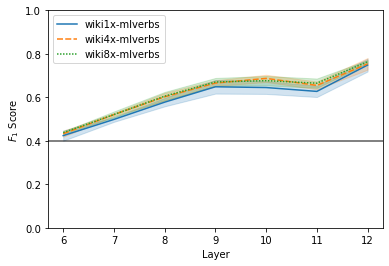

In [12]:
unseen_df = create_df(process_files(unseen_verb_files))
unseen_plot = create_single_plot(unseen_df)
save(
    plot=unseen_plot,
    filepath=os.path.join(basepath, f"plots/{modelname}_unseen_verbs_x_data_size.png")
)


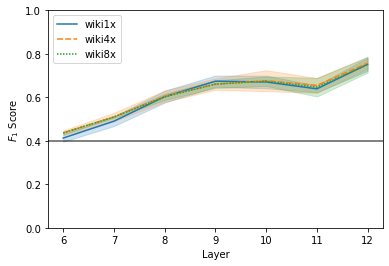

In [13]:
og_df = create_df(process_files(og_files))
og_plot = create_single_plot(og_df)
save(
    plot=og_plot,
    filepath=os.path.join(basepath, f"plots/{modelname}_seen_verbs_x_data_size.png")
)

In [14]:
ogdf = create_df(process_files(og_files))
unseendf = create_df(process_files(unseen_verb_files))
layers = ogdf['layer'].unique()
models = ogdf['model'].unique()

In [15]:
means = {
    'layer': [],
    'model': [],
    'diff': []
}

for l in layers:
    # means[l] = {}
    for m in models:

        unseenmodel = f'{m}-mlverbs'
        
        ogfilter = ogdf[ogdf.layer.eq(l) & ogdf.model.eq(m)]
        unseenfilter = unseendf[unseendf.layer.eq(l) & unseendf.model.eq(unseenmodel)]

        diffs = ogfilter['f1'].to_frame('a').reset_index().drop('index', axis=1)
        diffs['b'] = unseenfilter['f1'].to_frame('b').reset_index().drop('index', axis=1)

        differences = (diffs['a'].values - diffs['b'].values[:, None]).flatten()

        # means[l][m] = differences
        means['layer'].extend([l] * len(differences))
        means['model'].extend([m] * len(differences))
        means['diff'].extend(differences)

meandf = pd.DataFrame.from_dict(means)

In [14]:
def create_difference_plot(diffdf):
    # dashed lines
    dash_list = sns._core.unique_dashes(diffdf['model'].unique().size+1)
    style = {key:value for key,value in zip(diffdf['model'].unique(), dash_list)}

    # plot
    myplot = sns.lineplot(data=diffdf, x='layer', y='diff', hue='model', style='model', dashes=style, ci='sd')
    plt.xticks(sorted(set(diffdf.layer.values)))

    # set x- and y-axis labels
    myplot.set_ylabel('Differences')
    myplot.set_xlabel('Layer')

    # remove legend title
    myplot.get_legend().set_title(None)
    return myplot

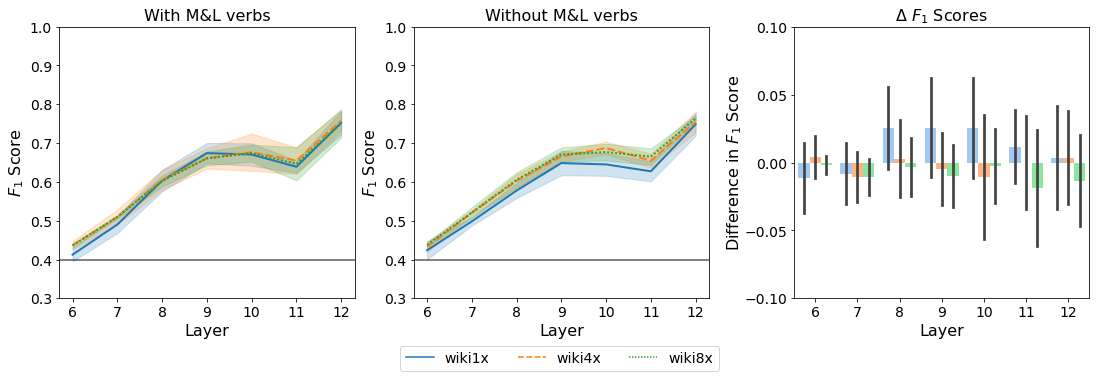

In [16]:
pal = sns.color_palette()

def tickformat(x):
    x = round(x, 2)
    return str(x)

#define dimensions of subplots (rows, columns)
nrows = 1
ncols = 3

# fig, axes = plt.subplots(5, 2,figsize=(10,10))
fig, axes = plt.subplots(nrows, ncols, figsize=(18,5))

# dashed lines
dash_list = sns._core.unique_dashes(6)
style={
    'wiki1x': dash_list[0], 'wiki1x-mlverbs': dash_list[0],
    'wiki4x-mlverbs': dash_list[1], 'wiki4x': dash_list[1],
    'wiki8x-mlverbs': dash_list[2], 'wiki8x': dash_list[2],
}

colors = {
    'wiki1x': pal[0],
    'wiki4x': pal[1],
    'wiki8x': pal[2],
    'wiki1x-mlverbs': pal[0],
    'wiki4x-mlverbs': pal[1],
    'wiki8x-mlverbs': pal[2],
}

ylims = (0.3, 1)
fontsize = 16
tickfontsize = 14
linewidth = 2

fig.add_subplot(axes[2])
diffplot = sns.barplot(data=meandf, x='layer', y='diff', hue='model', ci='sd', palette='pastel', saturation=1)
diffplot.set(ylim=(-0.10, 0.10))
diffplot.get_legend().remove()
diffplot.set_xlabel('Layer', fontsize=fontsize)
diffplot.set_ylabel('Difference in $F_{1}$ Score', fontsize=fontsize, labelpad=0)
diffplot.set(yticks=np.arange(-0.1, 0.11, 0.05))
diffplot.set_title(u'Δ $F_{1}$ Scores', fontsize=fontsize)

box = diffplot.get_position()
box.x0 = box.x0 + 0.02
box.x1 = box.x1 + 0.02
diffplot.set_position(box)

fig.add_subplot(axes[0])
ogplot = sns.lineplot(data=og_df, x='layer', y='f1', hue='model', style='model', dashes=style,  ci='sd', palette=colors, linewidth=linewidth)
ogplot.set(ylim=ylims)
ogplot.axhline(0.40, color=(0, 0, 0, 0.65))
ogplot.get_legend().set_title(None)
ogplot.legend(labels=['wiki-1x', 'wiki-4x', 'wiki-8x'])
# ogplot.legend(fontsize=20)
ogplot.legend(loc='center left', bbox_to_anchor=(1.13, -0.22), ncol=3, fontsize=14)
ogplot.set_xlabel('Layer', fontsize=fontsize)
ogplot.set_ylabel('$F_{1}$ Score', fontsize=fontsize)
ogplot.set_title('With M&L verbs', fontsize=fontsize)
# ogplot.set(yticks=np.arange(0.3, 1.1, 0.10))
# ogplot.set_yticklabels(ogplot.get_yticks(), size = 10)

fig.add_subplot(axes[1])
unseenplot = sns.lineplot(data=unseen_df, x='layer', y='f1', hue='model', style='model', dashes=style, ci='sd', palette=colors, linewidth=linewidth)
unseenplot.set(ylim=ylims)
unseenplot.axhline(0.40, color=(0, 0, 0, 0.65))
unseenplot.get_legend().remove()
unseenplot.set_xlabel('Layer', fontsize=fontsize)
unseenplot.set_ylabel('$F_{1}$ Score', fontsize=fontsize)
unseenplot.set_title('Without M&L verbs', fontsize=fontsize)

diffplot.tick_params(axis='both', which='major', labelsize=tickfontsize)
ogplot.tick_params(axis='both', which='major', labelsize=tickfontsize)
unseenplot.tick_params(axis='both', which='major', labelsize=tickfontsize)
# diffplot.tick_params(axis='both', which='minor', labelsize=8)


In [17]:
fig.savefig(
    os.path.join(basepath, f"plots/{modelname}_unseen_verbs_modified_eval_diffs_subplots.png"),
    bbox_inches='tight',
    dpi=300)